## Machine Learning Classification Model

### Cycling Predictor

### Aim
I don't want to say I'm a fair weather cyclist but my days of riding through heavy rain or having to combat brutal headwinds in the name of fitness are reaching an end. Using weather data sourced from the Australian Bureau of Meterology along with my personal cycling data retrieved from Strava (an exercise app), I will develop a model that can review the upcoming weather forecast and predict which days I am most likely to go riding based on my historic rides.

Things I consider: try to go for at least two rides a week, more as I'm training for an event. Rain. Best weather of the upcoming week.


### Data Cleaning

In [1]:
# load libraries
# for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for machine learning
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# load data
weather = pd.read_csv('Weather Data.csv')
cycling = pd.read_csv('Cycling Data.csv')

In [3]:
weather.head()

,"Daily Weather Observations for Melbourne, Victoria for July 2023 - August 2024",Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
0,NaN,2023-07-1,9.7,13.5,0.4,2.6,4.2,SSW,33.0,12:32,...,1,W,11,1023.2,11.3,89,6.0,SW,9,1025.8
1,NaN,2023-07-2,9.6,12.8,0.6,0.0,0.2,S,17.0,11:02,...,6,SW,6,1033.9,11.9,83,7.0,SSW,9,1032.7
2,NaN,2023-07-3,8.2,14.5,0.4,1.2,0.2,N,20.0,14:58,...,7,NNE,7,1030.4,14.1,64,7.0,N,13,1024.8
3,NaN,2023-07-4,8.3,13.6,0.0,0.8,0.0,NE,15.0,07:48,...,7,NNE,9,1017.9,13.4,77,8.0,NE,9,1012.7
4,NaN,2023-07-5,10.8,14.7,2.4,0.0,3.1,NNW,31.0,14:36,...,7,NW,4,1012.2,13.7,56,5.0,NNW,13,1011.2


When looking at the weather forecast, the main information provided is minimum and maximum temperatures, expected rain and wind speed. As this is the only information I have access to when deciding whether I'll go riding, any other information can be removed from our data set.

In [4]:
# drop columns
weather = weather.drop(columns=['Daily Weather Observations for Melbourne, Victoria for July 2023 - August 2024', 
                               'Evaporation (mm)', 'Direction of maximum wind gust ', 'Time of maximum wind gust', 
                               '9am Temperature (°C)', '9am relative humidity (%)', '9am cloud amount (oktas)', 
                               '9am wind direction', '9am MSL pressure (hPa)', '3pm Temperature (°C)', 
                                '3pm relative humidity (%)', '3pm wind direction', '3pm cloud amount (oktas)', '3pm MSL pressure (hPa)'])

In [5]:
weather.dtypes

Date                                  object
Minimum temperature (°C)             float64
Maximum temperature (°C)             float64
Rainfall (mm)                        float64
Sunshine (hours)                     float64
Speed of maximum wind gust (km/h)    float64
9am wind speed (km/h)                 object
3pm wind speed (km/h)                 object
dtype: object

In [6]:
weather = weather.convert_dtypes(infer_objects=True)
weather.dtypes
# where wind speed is missing, an adjective has been put in its place e.g. 'Calm'. 
# this is preventing wind speed from being converted into an integer

Date                                  string
Minimum temperature (°C)             Float64
Maximum temperature (°C)             Float64
Rainfall (mm)                        Float64
Sunshine (hours)                     Float64
Speed of maximum wind gust (km/h)      Int64
9am wind speed (km/h)                 string
3pm wind speed (km/h)                 string
dtype: object

In [7]:
# update missing wind speed with value from second wind speed column.
weather['9am wind speed (km/h)'] = np.where(weather['9am wind speed (km/h)'] == 'Calm', weather['3pm wind speed (km/h)'], weather['9am wind speed (km/h)'])
weather['3pm wind speed (km/h)'] = np.where(weather['3pm wind speed (km/h)'] == 'Calm', weather['9am wind speed (km/h)'], weather['3pm wind speed (km/h)'])
# convert data types
weather['9am wind speed (km/h)'] = pd.to_numeric(weather['9am wind speed (km/h)'], errors='coerce')
weather['3pm wind speed (km/h)'] = pd.to_numeric(weather['3pm wind speed (km/h)'], errors='coerce')
# convert to datetime format
weather['Date'] = pd.to_datetime(weather['Date'])
weather.dtypes

Date                                 datetime64[ns]
Minimum temperature (°C)                    Float64
Maximum temperature (°C)                    Float64
Rainfall (mm)                               Float64
Sunshine (hours)                            Float64
Speed of maximum wind gust (km/h)             Int64
9am wind speed (km/h)                         int64
3pm wind speed (km/h)                         int64
dtype: object

In [8]:
weather.head()

,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Sunshine (hours),Speed of maximum wind gust (km/h),9am wind speed (km/h),3pm wind speed (km/h)
0,2023-07-01,9.7,13.5,0.4,4.2,33,11,9
1,2023-07-02,9.6,12.8,0.6,0.2,17,6,9
2,2023-07-03,8.2,14.5,0.4,0.2,20,7,13
3,2023-07-04,8.3,13.6,0.0,0.0,15,9,9
4,2023-07-05,10.8,14.7,2.4,3.1,31,4,13


In [9]:
# check for missing data
weather[pd.isnull(weather).any(axis=1)]

,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Sunshine (hours),Speed of maximum wind gust (km/h),9am wind speed (km/h),3pm wind speed (km/h)
39,2023-08-09,5.5,18.4,0.2,8.5,<NA>,13,24
241,2024-02-27,12.9,27.4,0.0,10.9,<NA>,7,11
342,2024-06-07,9.3,16.0,0.0,1.7,<NA>,7,13


The missing data in the maximum wind gust column will be corrected once the two data sets have been merged and the wind speed columns have been merged into one based on activity time

In [10]:
print(cycling.columns)
# drop columns
cycling = cycling[['Activity Date', 'Moving Time', 'Distance.1', 'Average Speed', 'Elevation Gain',
                   'Average Temperature']]

Index(['Activity ID', 'Activity Date', 'Activity Name', 'Activity Type',
       'Activity Description', 'Elapsed Time', 'Distance', 'Max Heart Rate',
       'Relative Effort', 'Commute', 'Activity Private Note', 'Activity Gear',
       'Filename', 'Athlete Weight', 'Bike Weight', 'Elapsed Time.1',
       'Moving Time', 'Distance.1', 'Max Speed', 'Average Speed',
       'Elevation Gain', 'Elevation Loss', 'Elevation Low', 'Elevation High',
       'Max Grade', 'Average Grade', 'Average Positive Grade',
       'Average Negative Grade', 'Max Cadence', 'Average Cadence',
       'Max Heart Rate.1', 'Average Heart Rate', 'Max Watts', 'Average Watts',
       'Calories', 'Max Temperature', 'Average Temperature',
       'Relative Effort.1', 'Total Work', 'Number of Runs', 'Uphill Time',
       'Downhill Time', 'Other Time', 'Perceived Exertion', 'Type',
       'Start Time', 'Weighted Average Power', 'Power Count',
       'Prefer Perceived Exertion', 'Perceived Relative Effort', 'Commute.1',
    

In [11]:
# check for missing data in our df
cycling[pd.isnull(cycling).any(axis=1)]

,Activity Date,Moving Time,Distance.1,Average Speed,Elevation Gain,Average Temperature


In [12]:
cycling.head()

,Activity Date,Moving Time,Distance.1,Average Speed,Elevation Gain,Average Temperature
0,"5 Jul 2023, 06:40:41",3704.0,30432.550781,8.216131,30.0,11.0
1,"10 Jul 2023, 06:55:26",3748.0,30410.199219,8.113714,70.0,13.0
2,"12 Jul 2023, 07:39:00",4412.0,35607.578125,8.070621,40.0,13.0
3,"19 Jul 2023, 07:11:12",4264.0,35598.378906,8.348588,40.0,9.0
4,"21 Jul 2023, 01:48:48",3636.0,31191.509766,8.578523,59.0,13.0


In [13]:
# from this view, I can see that all times assigned to the activites are ten hours behind
# convert Activity Date into a datetime object
cycling['Activity Date'] = pd.to_datetime(cycling['Activity Date'], format='%d %b %Y, %H:%M:%S')
# add ten hours to each value
cycling['Activity Date'] = cycling['Activity Date'] + pd.to_timedelta(10, unit='h')

In [14]:
# split Activity Date column into separate Date and Time columns with Date matching the formatting from weather dataframe.
cycling['Date'] = pd.to_datetime(cycling['Activity Date'], format='%d %b %Y, %H:%M:%S').dt.strftime('%Y-%m-%d')
cycling['Time'] = pd.to_datetime(cycling['Activity Date'], format='%d %b %Y, %H:%M:%S').dt.strftime('%H:%M:%S')
# drop original Activity Date column
cycling = cycling.drop(columns=['Activity Date'])
# Move Date and Time columns to front
cycling.insert(0, 'Date', cycling.pop('Date'))
cycling.insert(1, 'Time', cycling.pop('Time'))
# update data types
cycling['Date'] = pd.to_datetime(cycling['Date'])
cycling['Time'] = pd.to_datetime(cycling['Time'])
# remove date from Time column
cycling['Time'] = pd.to_datetime(cycling['Time'], format='%d %b %Y, %H:%M:%S').dt.strftime('%H:%M:%S')

In [15]:
# adjust data values
# Edit Moving Time to minutes
cycling['Moving Time'] = (cycling['Moving Time'] / 60).round(2)
# Edit Distance column name and convert from meters to kilometers
cycling.rename(columns = {'Distance.1':'Distance'}, inplace = True)
cycling['Distance'] = (cycling['Distance'] / 1000).round(2)
# Convert Average Speed to kmph
cycling['Average Speed'] = (cycling['Average Speed'] * 3.6).round(2)

In [16]:
cycling.head()

,Date,Time,Moving Time,Distance,Average Speed,Elevation Gain,Average Temperature
0,2023-07-05,16:40:41,61.73,30.43,29.58,30.0,11.0
1,2023-07-10,16:55:26,62.47,30.41,29.21,70.0,13.0
2,2023-07-12,17:39:00,73.53,35.61,29.05,40.0,13.0
3,2023-07-19,17:11:12,71.07,35.60,30.05,40.0,9.0
4,2023-07-21,11:48:48,60.60,31.19,30.88,59.0,13.0


In [17]:
# update column names
cycling.rename(columns={'Moving Time': 'Moving Time (mins)', 'Distance': 'Distance (km)', 'Average Speed': 'Average Speed (km/h)', 'Elevation Gain': 'Elevation Gain (m)', 'Average Temperature': 'Average Temperature during ride'}, inplace=True)

In [18]:
cycling.describe()

,Moving Time (mins),Distance (km),Average Speed (km/h),Elevation Gain (m),Average Temperature during ride
count,101.000000,101.000000,101.000000,101.000000,101.000000
mean,88.165743,41.256634,28.876634,216.213974,16.138614
std,76.734546,30.807512,2.379215,390.472530,6.823532
min,21.130000,9.810000,20.690000,8.000000,4.000000
25%,60.870000,30.450000,28.420000,41.924999,11.000000
50%,69.470000,33.920000,29.700000,46.320000,14.000000
75%,85.170000,40.750000,30.370000,148.000000,22.000000
max,740.600000,294.510000,32.320000,2643.000000,33.000000


In [19]:
weather.describe()

,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Sunshine (hours),Speed of maximum wind gust (km/h),9am wind speed (km/h),3pm wind speed (km/h)
count,425.000000,425.000000,425.000000,425.000000,422.000000,425.000000,425.000000
mean,11.175765,19.631059,1.479529,6.087765,33.938389,9.903529,13.498824
std,4.179521,5.591826,4.683087,3.833017,11.467024,4.785750,5.588957
min,1.000000,10.100000,0.000000,0.000000,13.000000,2.000000,2.000000
25%,8.200000,15.500000,0.000000,3.000000,26.000000,7.000000,9.000000
50%,11.000000,18.600000,0.000000,6.500000,33.000000,9.000000,13.000000
75%,14.200000,22.400000,0.800000,9.400000,41.000000,13.000000,17.000000
max,22.800000,37.600000,53.200000,13.200000,70.000000,28.000000,33.000000


In [20]:
# merge data sets based on Date column
combineddf = weather.merge(cycling, how='left', on='Date')

In [21]:
# based on column counts all data exists
combineddf.describe()

,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Sunshine (hours),Speed of maximum wind gust (km/h),9am wind speed (km/h),3pm wind speed (km/h),Moving Time (mins),Distance (km),Average Speed (km/h),Elevation Gain (m),Average Temperature during ride
count,425.000000,425.000000,425.000000,425.000000,422.000000,425.000000,425.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,11.175765,19.631059,1.479529,6.087765,33.938389,9.903529,13.498824,88.165743,41.256634,28.876634,216.213974,16.138614
std,4.179521,5.591826,4.683087,3.833017,11.467024,4.785750,5.588957,76.734546,30.807512,2.379215,390.472530,6.823532
min,1.000000,10.100000,0.000000,0.000000,13.000000,2.000000,2.000000,21.130000,9.810000,20.690000,8.000000,4.000000
25%,8.200000,15.500000,0.000000,3.000000,26.000000,7.000000,9.000000,60.870000,30.450000,28.420000,41.924999,11.000000
50%,11.000000,18.600000,0.000000,6.500000,33.000000,9.000000,13.000000,69.470000,33.920000,29.700000,46.320000,14.000000
75%,14.200000,22.400000,0.800000,9.400000,41.000000,13.000000,17.000000,85.170000,40.750000,30.370000,148.000000,22.000000
max,22.800000,37.600000,53.200000,13.200000,70.000000,28.000000,33.000000,740.600000,294.510000,32.320000,2643.000000,33.000000


## Data preparation

Adding and editing columns
1. Create Boolean column indicating 0 for no ride and 1 for ride occured. This will be used when training the model.

2. New wind column that selects the 9am or 3pm value based on time of ride. then drop time column.

3. Then add column with min/max temp in comparison to last 4 day average, same for wind, same for rain. This is because it's not the explicit weather that determines if I'll go cycling or else I just wouldn't ride in winter. The days I choose to go riding are likely the nicer days of that week.

In [22]:
#create a boolean Ride YN (1/0) column
# initialise column with zeros
combineddf.insert(8, 'Cycling Activity (Y/N)', 0)
# edit value to equal 1 where cycling data exists
combineddf.loc[combineddf['Moving Time (mins)'].notna(), 'Cycling Activity (Y/N)'] = 1

In [23]:
combineddf.head()

,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Sunshine (hours),Speed of maximum wind gust (km/h),9am wind speed (km/h),3pm wind speed (km/h),Cycling Activity (Y/N),Time,Moving Time (mins),Distance (km),Average Speed (km/h),Elevation Gain (m),Average Temperature during ride
0,2023-07-01,9.7,13.5,0.4,4.2,33,11,9,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-07-02,9.6,12.8,0.6,0.2,17,6,9,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-07-03,8.2,14.5,0.4,0.2,20,7,13,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-07-04,8.3,13.6,0.0,0.0,15,9,9,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-07-05,10.8,14.7,2.4,3.1,31,4,13,1,16:40:41,61.73,30.43,29.58,30.0,11.0


In [24]:
# convert Time column to datetime data type keeping just time portion
combineddf['Time'] = pd.to_datetime(combineddf['Time'], format='%H:%M:%S').dt.time

# create single wind speed column based on time of ride e.g. if Time is before midday use 9am wind speed, 
# if time is after midday use 3pm wind speed, if no ride occurred, use average of the two columns
combineddf['Wind speed (km/h)'] = combineddf.apply(
    lambda row: np.nanmean([row['9am wind speed (km/h)'], row['3pm wind speed (km/h)']]) if pd.isna(row['Time'])
    else row['9am wind speed (km/h)'] if row['Time'].hour < 12
    else row['3pm wind speed (km/h)'],
    axis=1
)

In [25]:
combineddf.head()

,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Sunshine (hours),Speed of maximum wind gust (km/h),9am wind speed (km/h),3pm wind speed (km/h),Cycling Activity (Y/N),Time,Moving Time (mins),Distance (km),Average Speed (km/h),Elevation Gain (m),Average Temperature during ride,Wind speed (km/h)
0,2023-07-01,9.7,13.5,0.4,4.2,33,11,9,0,NaT,NaN,NaN,NaN,NaN,NaN,10.0
1,2023-07-02,9.6,12.8,0.6,0.2,17,6,9,0,NaT,NaN,NaN,NaN,NaN,NaN,7.5
2,2023-07-03,8.2,14.5,0.4,0.2,20,7,13,0,NaT,NaN,NaN,NaN,NaN,NaN,10.0
3,2023-07-04,8.3,13.6,0.0,0.0,15,9,9,0,NaT,NaN,NaN,NaN,NaN,NaN,9.0
4,2023-07-05,10.8,14.7,2.4,3.1,31,4,13,1,16:40:41,61.73,30.43,29.58,30.0,11.0,13.0


In [26]:
# drop the Time, 9am and 3pm columns.
combineddf = combineddf.drop(columns=['Time', '9am wind speed (km/h)', '3pm wind speed (km/h)'])
# Move the new Wind Speed column to be with the weather columns.
combineddf.insert(6, 'Wind speed (km/h)', combineddf.pop('Wind speed (km/h)'))

Create new columns for min temp, max temp, rainfall and wind speed that display the average value of the previous 4 days. This allows us to easily compare the current weather to that of the previous days and helps factor in changing average weather throughout the year.

In [27]:
# create columns to view how that days weather differed from the previous 4 day average
# Shift the column by 1 day to exclude the current day from the rolling window
combineddf['Shifted Col'] = combineddf['Minimum temperature (°C)'].shift(1)
# calculate 4-day rolling average Min Temp
combineddf['4_day_avg'] = combineddf['Shifted Col'].rolling(window=4).mean()
# calculate the difference between Min Temp and the 4-day rolling average
combineddf.insert(2, '4DAvg Difference (Min Temp)', combineddf['Minimum temperature (°C)'] - combineddf['4_day_avg'])


# Shift the column by 1 day to exclude the current day from the rolling window
combineddf['Shifted Col'] = combineddf['Maximum temperature (°C)'].shift(1)
# calculate 4-day rolling average Max Temp
combineddf['4_day_avg'] = combineddf['Shifted Col'].rolling(window=4).mean()
# calculate the difference between Max Temp and the 5-day rolling average
combineddf.insert(4, '4DAvg Difference (Max Temp)', combineddf['Maximum temperature (°C)'] - combineddf['4_day_avg'])


# Shift the column by 1 day to exclude the current day from the rolling window
combineddf['Shifted Col'] = combineddf['Rainfall (mm)'].shift(1)
# calculate 4-day rolling average Rainfall
combineddf['4_day_avg'] = combineddf['Shifted Col'].rolling(window=4).mean()
# calculate the difference between Rainfall and the 4-day rolling average
combineddf.insert(6, '4DAvg Difference (Rainfall)', combineddf['Rainfall (mm)'] - combineddf['4_day_avg'])


# Shift the column by 1 day to exclude the current day from the rolling window
combineddf['Shifted Col'] = combineddf['Wind speed (km/h)'].shift(1)
# calculate 4-day rolling average Wind Speed
combineddf['4_day_avg'] = combineddf['Shifted Col'].rolling(window=4).mean()
# calculate the difference between Rainfall and the 4-day rolling average
combineddf.insert(10, '4DAvg Difference (Wind Speed)', combineddf['Wind speed (km/h)'] - combineddf['4_day_avg'])

# drop columns
combineddf = combineddf.drop(columns=['Shifted Col', '4_day_avg'])

In [28]:
# drop the 4 rows with missing values in the 4DAvg columns
combineddf.drop(index=range(0,4), axis=0, inplace=True)
# reset the index
combineddf = combineddf.reset_index(drop=True)

In [29]:
# convert wind gust column to float
combineddf['Speed of maximum wind gust (km/h)'] = combineddf['Speed of maximum wind gust (km/h)'].astype('float64')
# fill missing max gust values based on average of corresponding wind speed values
avg_gust = combineddf.loc[combineddf['Wind speed (km/h)'] == 18.5, 'Speed of maximum wind gust (km/h)'].mean()
combineddf.loc[(combineddf['Wind speed (km/h)'] == 18.5) & (combineddf['Speed of maximum wind gust (km/h)'].isna()), 
               'Speed of maximum wind gust (km/h)'] = avg_gust


avg_gust = combineddf.loc[combineddf['Wind speed (km/h)'] == 11.0, 'Speed of maximum wind gust (km/h)'].mean()
combineddf.loc[(combineddf['Wind speed (km/h)'] == 11.0) & (combineddf['Speed of maximum wind gust (km/h)'].isna()), 
               'Speed of maximum wind gust (km/h)'] = avg_gust

avg_gust = combineddf.loc[combineddf['Wind speed (km/h)'] == 10.0, 'Speed of maximum wind gust (km/h)'].mean()
combineddf.loc[(combineddf['Wind speed (km/h)'] == 10.0) & (combineddf['Speed of maximum wind gust (km/h)'].isna()), 
               'Speed of maximum wind gust (km/h)'] = avg_gust

In [30]:
combineddf.tail(50)

,Date,Minimum temperature (°C),4DAvg Difference (Min Temp),Maximum temperature (°C),4DAvg Difference (Max Temp),Rainfall (mm),4DAvg Difference (Rainfall),Sunshine (hours),Speed of maximum wind gust (km/h),Wind speed (km/h),4DAvg Difference (Wind Speed),Cycling Activity (Y/N),Moving Time (mins),Distance (km),Average Speed (km/h),Elevation Gain (m),Average Temperature during ride
371,2024-07-10,10.2,5.225,14.3,0.025,11.8,9.7,3.8,35.0,9.0,-2.750,1,85.17,41.89,29.51,42.000000,9.0
372,2024-07-11,9.7,3.1,13.6,-1.625,0.0,-5.05,0.3,52.0,22.5,9.625,0,NaN,NaN,NaN,NaN,NaN
373,2024-07-12,10.2,2.025,14.8,0.4,3.6,-1.45,5.1,30.0,5.5,-9.750,0,NaN,NaN,NaN,NaN,NaN
374,2024-07-13,7.9,-1.95,13.7,-0.25,0.8,-5.15,5.2,24.0,7.0,-4.125,1,100.38,46.40,27.73,42.000000,6.0
375,2024-07-14,6.8,-2.7,12.0,-2.1,3.4,-0.65,3.4,30.0,10.0,-1.000,0,NaN,NaN,NaN,NaN,NaN
376,2024-07-15,7.3,-1.35,12.1,-1.425,1.2,-0.75,0.7,41.0,14.0,2.750,0,NaN,NaN,NaN,NaN,NaN
377,2024-07-16,9.0,0.95,13.6,0.45,19.6,17.35,0.0,37.0,9.0,-0.125,0,NaN,NaN,NaN,NaN,NaN
378,2024-07-17,8.6,0.85,14.0,1.15,0.2,-6.05,1.2,33.0,8.5,-1.500,0,NaN,NaN,NaN,NaN,NaN
379,2024-07-18,7.3,-0.625,12.1,-0.825,1.0,-5.1,3.9,28.0,7.5,-2.875,0,NaN,NaN,NaN,NaN,NaN
380,2024-07-19,7.7,-0.35,12.1,-0.85,0.0,-5.5,0.1,57.0,24.0,14.250,0,NaN,NaN,NaN,NaN,NaN


### Initial Analysis

To analyze cycling habits, including how frequently you ride, how weather conditions affect your riding decisions, and patterns in your cycling behavior over time.

Visuals
How often do I ride, what days do I ride
scatter plot with time and distance coloured by day of week? coloured by temperature?

Features to Consider:

    Weather Data:
        Daily weather conditions
        Historical weather data
    Cycling Data:
        Number of rides per week
        Distance and duration of each ride
        Frequency of rides on specific days of the week
        Rest days
        

In [31]:
# number of rides in the 6 months of data
a = (combineddf['Cycling Activity (Y/N)'] == 1).sum()
print('Number of rides during the thirteen months of data collection:', a)

# average number of rides per week
# extract the week number using the date column and count
unique_weeks = combineddf['Date'].dt.isocalendar().week.nunique()

print('Average number of rides per week:', round(a/unique_weeks, 2))

Number of rides during the thirteen months of data collection: 101
Average number of rides per week: 1.94


Not many! I've gotta lift my game!

In [32]:
combineddf.head(20)

,Date,Minimum temperature (°C),4DAvg Difference (Min Temp),Maximum temperature (°C),4DAvg Difference (Max Temp),Rainfall (mm),4DAvg Difference (Rainfall),Sunshine (hours),Speed of maximum wind gust (km/h),Wind speed (km/h),4DAvg Difference (Wind Speed),Cycling Activity (Y/N),Moving Time (mins),Distance (km),Average Speed (km/h),Elevation Gain (m),Average Temperature during ride
0,2023-07-05,10.8,1.85,14.7,1.1,2.4,2.05,3.1,31.0,13.0,3.875,1,61.73,30.43,29.58,30.0,11.0
1,2023-07-06,10.0,0.775,15.2,1.3,0.0,-0.85,7.3,50.0,19.5,9.625,0,NaN,NaN,NaN,NaN,NaN
2,2023-07-07,9.9,0.575,15.5,1.0,1.0,0.3,6.8,39.0,14.0,1.125,0,NaN,NaN,NaN,NaN,NaN
3,2023-07-08,10.5,0.75,14.9,0.15,1.2,0.35,6.8,52.0,20.5,6.625,0,NaN,NaN,NaN,NaN,NaN
4,2023-07-09,10.9,0.6,16.9,1.825,0.2,-0.95,3.5,39.0,10.0,-6.750,0,NaN,NaN,NaN,NaN,NaN
5,2023-07-10,11.9,1.575,17.1,1.475,0.8,0.2,4.7,44.0,19.0,3.000,1,62.47,30.41,29.21,70.0,13.0
6,2023-07-11,11.6,0.8,17.6,1.5,0.4,-0.4,4.8,28.0,9.0,-6.875,0,NaN,NaN,NaN,NaN,NaN
7,2023-07-12,11.1,-0.125,17.7,1.075,0.0,-0.65,7.8,39.0,20.0,5.375,1,73.53,35.61,29.05,40.0,13.0
8,2023-07-13,9.5,-1.875,15.9,-1.425,0.0,-0.35,4.5,52.0,22.5,8.000,0,NaN,NaN,NaN,NaN,NaN
9,2023-07-14,11.0,-0.025,14.7,-2.375,0.0,-0.3,0.3,48.0,23.5,5.875,0,NaN,NaN,NaN,NaN,NaN


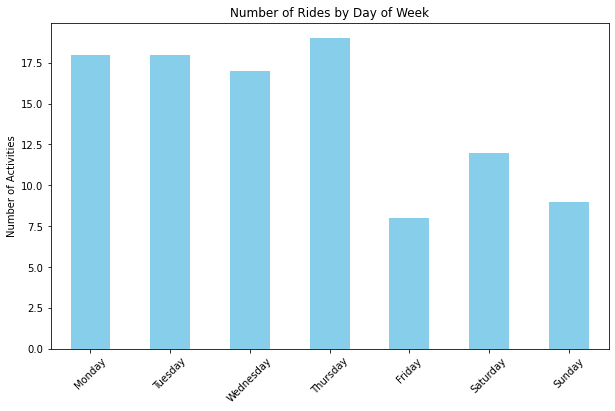

In [33]:
# create weekday column
combineddf.insert(1, "Weekday", combineddf['Date'].dt.day_name())
# count number of activities that fall on each day
activity_count = combineddf[combineddf['Cycling Activity (Y/N)'] == 1]['Weekday'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fill_value=0)
# plot number of rides by day of week
plt.figure(figsize=(10, 6))
activity_count.plot(kind='bar', color='skyblue')
plt.title('Number of Rides by Day of Week')
plt.ylabel('Number of Activities')
plt.xticks(rotation=45)
plt.show()





In [34]:
# Proportion of positive and negative 5 day average values when I've gone for a ride.
# Filter the DataFrame for only where Ive gone riding
filtered_df = combineddf[combineddf['Cycling Activity (Y/N)'] == 1]

# Count the number of positive and negative values in the Min Temp column
positive_count = (filtered_df['4DAvg Difference (Min Temp)'] > 0).sum()
negative_count = (filtered_df['4DAvg Difference (Min Temp)'] < 0).sum()

print("Min Temp")
print(f"Number of positive values: {positive_count}")
print(f"Number of negative values: {negative_count}")

# Count the number of positive and negative values in the Max Temp column
positive_count = (filtered_df['4DAvg Difference (Max Temp)'] > 0).sum()
negative_count = (filtered_df['4DAvg Difference (Max Temp)'] < 0).sum()

print("Max Temp")
print(f"Number of positive values: {positive_count}")
print(f"Number of negative values: {negative_count}")

# Count the number of positive and negative values in the Rainfall column
positive_count = (filtered_df['4DAvg Difference (Rainfall)'] > 0).sum()
negative_count = (filtered_df['4DAvg Difference (Rainfall)'] < 0).sum()

print("Rainfall")
print(f"Number of positive values: {positive_count}")
print(f"Number of negative values: {negative_count}")

# Count the number of positive and negative values in the Wind Speed column
positive_count = (filtered_df['4DAvg Difference (Wind Speed)'] > 0).sum()
negative_count = (filtered_df['4DAvg Difference (Wind Speed)'] < 0).sum()

print("Wind Speed")
print(f"Number of positive values: {positive_count}")
print(f"Number of negative values: {negative_count}")


Min Temp
Number of positive values: 43
Number of negative values: 58
Max Temp
Number of positive values: 51
Number of negative values: 50
Rainfall
Number of positive values: 25
Number of negative values: 50
Wind Speed
Number of positive values: 46
Number of negative values: 53


Surprisingly more often going out on cooler days. Looks like rainfall is the biggest deciding factor.

### Machine Learning

Aim: I will be making a machine learning model that can predict my likelihood of riding depending on the upcoming weather forecast. I will use the following models: 

Logistic Regression for baseline - scaling/normalisation not required
Random Forest - Scaling / normalisation not required - provide feature importance score
Gradient Boosting - XGBoost - provide feature importance score
    





Firstly, convert categorical weekday column into separate binary columns using OHE


In [35]:
# firstly encode our Weekday categorical data using One Hot Encoder
# initialise encoder
encoder = OneHotEncoder(sparse=False)

# fit and transform the data
encoded_array = encoder.fit_transform(combineddf[['Weekday']])

# create new dataframe with the encoded data
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['Weekday']))

# merge with original "combineddf" dataframe
combineddf = pd.concat([combineddf, encoded_df], axis=1)

In [36]:
# drop irrelevant columns to reduce complexity and noise
# date and weekday column no longer needed as are the cycling details columns
combineddf = combineddf.drop(columns=['Date', 'Weekday', 'Moving Time (mins)', 'Distance (km)', 
                                      'Average Speed (km/h)', 'Elevation Gain (m)', 
                                      'Average Temperature during ride'])

#Check that number of rows is at least 5 x the number of features
len(combineddf)

421

### Logistic Regression

In [37]:
# move binary cycling activity indicator column to start of dataframe for clarity
combineddf.insert(0, 'Cycling Activity (Y/N)', combineddf.pop('Cycling Activity (Y/N)'))
combineddf.head()

,Cycling Activity (Y/N),Minimum temperature (°C),4DAvg Difference (Min Temp),Maximum temperature (°C),4DAvg Difference (Max Temp),Rainfall (mm),4DAvg Difference (Rainfall),Sunshine (hours),Speed of maximum wind gust (km/h),Wind speed (km/h),4DAvg Difference (Wind Speed),Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,1,10.8,1.85,14.7,1.1,2.4,2.05,3.1,31.0,13.0,3.875,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,10.0,0.775,15.2,1.3,0.0,-0.85,7.3,50.0,19.5,9.625,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,9.9,0.575,15.5,1.0,1.0,0.3,6.8,39.0,14.0,1.125,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,10.5,0.75,14.9,0.15,1.2,0.35,6.8,52.0,20.5,6.625,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,10.9,0.6,16.9,1.825,0.2,-0.95,3.5,39.0,10.0,-6.750,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [38]:
# assign features and target
X = pd.concat([combineddf.iloc[:, 1:18]], axis=1)
y = combineddf['Cycling Activity (Y/N)']

In [39]:
# split data into training and testing with stratified sampling to preserve classification weightings
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=12)

In [40]:
# standardise data to avoid convergence warning
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
# initialise and train regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

In [42]:
# evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Accuracy: 0.7529411764705882
Confusion Matrix:
[[62  3]
 [18  2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.95      0.86        65
           1       0.40      0.10      0.16        20

    accuracy                           0.75        85
   macro avg       0.59      0.53      0.51        85
weighted avg       0.69      0.75      0.69        85



model has 75% accuracy in predicting whether I would go cycling on a particular day, however our results show that it is much better at predicting when I won't go cycling than when I will, correctly predicting 62 of the 65 days that I didn't go cycling but incorrectly predicting that I wouldn't go cycling on 18 days that I did. An f1 score of 0.16 confirms the model's difficulty in predicting days I go riding.

The model appears to be biased towards predicting when I won't go cycling which is likely due to the imbalance in the dataset where "not cycling" is more common than "cycling."

Of course there are many more factors that go into whether I go riding than just the weather such as work deadlines, injuries, university assignments and illness. Using my calendar I will remove dates where I know there were other reasons that caused me not to go riding and will run the model again.

In [43]:
# re add Date column
combineddf.insert(0, 'Date', pd.date_range(start='2023-07-05', periods=len(combineddf), freq='D'))

In [44]:
combineddf.tail()

,Date,Cycling Activity (Y/N),Minimum temperature (°C),4DAvg Difference (Min Temp),Maximum temperature (°C),4DAvg Difference (Max Temp),Rainfall (mm),4DAvg Difference (Rainfall),Sunshine (hours),Speed of maximum wind gust (km/h),Wind speed (km/h),4DAvg Difference (Wind Speed),Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
416,2024-08-24,1,13.8,3.35,21.8,3.075,4.2,2.8,10.3,63.0,13.0,-0.750,0.0,0.0,1.0,0.0,0.0,0.0,0.0
417,2024-08-25,0,12.0,0.05,23.5,3.8,0.0,-2.35,3.8,61.0,16.5,3.250,0.0,0.0,0.0,1.0,0.0,0.0,0.0
418,2024-08-26,1,12.8,0.825,18.6,-2.175,11.6,9.55,5.4,31.0,11.0,-3.375,0.0,1.0,0.0,0.0,0.0,0.0,0.0
419,2024-08-27,0,12.4,0.05,20.2,-0.5,0.0,-3.95,1.3,63.0,25.0,10.125,0.0,0.0,0.0,0.0,0.0,1.0,0.0
420,2024-08-28,0,14.0,1.25,18.6,-2.425,0.2,-3.75,7.9,57.0,19.5,3.125,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [45]:
# dates to remove
remove_dates = ['2023-07-09', '2023-07-14', '2023-07-15', '2023-07-16', '2023-07-17', '2023-07-28', 
                     '2023-07-29', '2023-07-30', '2023-08-26', '2023-09-04', '2023-09-05', '2023-09-06', 
                    '2023-09-07', '2023-09-08', '2023-09-09', '2023-09-10', '2023-09-16', '2023-09-17', 
                    '2023-10-03', '2023-10-04', '2023-10-05', '2023-10-06', '2023-10-07', '2023-10-08', 
                    '2023-10-16', '2023-10-17', '2023-10-18', '2023-10-19', '2023-10-20', '2023-10-21', 
                    '2023-10-22', '2023-10-23', '2023-10-24', '2023-10-25', '2023-10-26', '2023-10-27', 
                    '2023-11-06', '2023-11-07', '2023-11-18', '2023-11-19', '2023-12-25', '2023-12-26', 
                    '2023-12-27', '2023-12-28', '2023-12-29', '2023-12-30', '2023-12-31', '2024-01-01', 
                     '2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-06', '2024-01-07', 
                     '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-19', 
                     '2024-01-20', '2024-01-21', '2024-02-12', '2024-02-13', '2024-02-14', '2024-02-15', 
                     '2024-02-16', '2024-02-17', '2024-02-18', '2024-03-09', '2024-03-10', '2024-03-11', 
                     '2024-03-19', '2024-03-20', '2024-03-21', '2024-03-22', '2024-03-23', '2024-03-27', 
                    '2024-03-28', '2024-03-29', '2024-03-30', '2024-03-31', '2024-04-17', '2024-04-18', 
                     '2024-04-19', '2024-04-20', '2024-04-21', '2024-05-20', '2024-05-21', '2024-05-22', 
                    '2024-05-23', '2024-05-24', '2024-05-25', '2024-05-26', '2024-05-27', '2024-05-28', 
                    '2024-05-29', '2024-05-30', '2024-05-31', '2024-06-01', '2024-06-02', '2024-06-03', 
                     '2024-06-04', '2024-06-05', '2024-06-06', '2024-06-07', '2024-06-08', '2024-06-09', 
                     '2024-06-10', '2024-06-11', '2024-06-12', '2024-06-13', '2024-06-14', '2024-06-15', 
                     '2024-07-16', '2024-07-17', '2024-07-18', '2024-07-19', '2024-08-04', '2024-08-05', 
                     '2024-08-06']

# convert to datetime
remove_dates = pd.to_datetime(remove_dates)

# remove dates
combineddf = combineddf[~combineddf['Date'].isin(remove_dates)]
# drop Date column
combineddf = combineddf.drop(columns=['Date'])
combineddf = combineddf.reset_index(drop=True)

In [46]:
combineddf.to_csv('currentforecast.csv', index=False)

Run the linear regression model on the refined dataset

In [176]:
# train regression model
# assign features and target
X = pd.concat([combineddf.iloc[:, 1:18]], axis=1)
y = combineddf['Cycling Activity (Y/N)']
# split data into training and testing with stratified sampling to preserve classification weightings
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=12)
# standardise data to avoid convergence warning
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# initialise and train regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

In [178]:
# evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Accuracy: 0.7333333333333333
Confusion Matrix:
[[36  5]
 [11  8]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82        41
           1       0.62      0.42      0.50        19

    accuracy                           0.73        60
   macro avg       0.69      0.65      0.66        60
weighted avg       0.72      0.73      0.72        60



Model accuracy appears to have slightly dropped but the results have actually greatly improved in terms of predicting when I will go cycling. Of all the days where I went riding, the model can now predict 42% of them correctly (up from 10%). It is still biased towards predicting days that I won't go riding but this indicates gathering more data to balance the classes.

I will now assess the performance of the RandomForestClassifier and XGBoost models before developing the final output based on %likelihood.

### Random Forest Classifier

In [193]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=16)

# Initialize the RandomForest model
randomforest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
randomforest_model.fit(X_train, y_train)

# Predict on the test data
y_pred = randomforest_model.predict(X_test)

In [194]:
# evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Accuracy: 0.7166666666666667
Confusion Matrix:
[[37  4]
 [13  6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.90      0.81        41
           1       0.60      0.32      0.41        19

    accuracy                           0.72        60
   macro avg       0.67      0.61      0.61        60
weighted avg       0.70      0.72      0.69        60



### XGBoost

In [189]:
from xgboost import XGBClassifier

In [195]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

# Initialize the XGBoost model
xgboost_model = XGBClassifier(n_estimators=100, random_state=42)

# Train the model
xgboost_model.fit(X_train, y_train)

# Predict on the test data
y_pred = xgboost_model.predict(X_test)

/Users/simoncrouch/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:38:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "stratify" } are not used.

  warnings.warn(smsg, UserWarning)


In [191]:
# evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Accuracy: 0.7333333333333333
Confusion Matrix:
[[39  8]
 [ 8  5]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        47
           1       0.38      0.38      0.38        13

    accuracy                           0.73        60
   macro avg       0.61      0.61      0.61        60
weighted avg       0.73      0.73      0.73        60



### Results

Surprisingly the logistical regression model provides the best results.

Drop weekday column

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train, y_train)

# Get probability estimates
probabilities = model.predict_proba(X_test)[:, 1]  # Probability of going cycling

# Convert to percentages
percentages = probabilities * 100

# Evaluate the model as before
accuracy = accuracy_score(y_test, model.predict(X_test))
print(f'Accuracy: {accuracy}')
cm = confusion_matrix(y_test, model.predict(X_test))
print('Confusion Matrix:')
print(cm)
report = classification_report(y_test, model.predict(X_test))
print('Classification Report:')
print(report)

# Display the probabilities
for i in range(5):  # Adjust the range as needed
    print(f'Weather on Day {i+1}: {X_test[i]}')
    print(f'Probability of going cycling: {percentages[i]:.2f}%\n')

Weather on Day 1: [-1.81320272  0.50084656 -0.47198581  1.30441733 -0.28713588  0.03753424
  0.25852653 -0.88317622  0.20675151  1.22412013 -0.41319694 -0.42008403
 -0.38513031  2.42015348 -0.42008403 -0.40626167 -0.3992747 ]
Probability of going cycling: 18.57%

Weather on Day 2: [ 1.39250328  0.7261571  -0.28794585 -2.08946547  0.35829924  0.6012253
 -1.68042242 -0.33078179 -1.07823798 -1.15492944 -0.41319694 -0.42008403
  2.59652373 -0.41319694 -0.42008403 -0.40626167 -0.3992747 ]
Probability of going cycling: 9.95%

Weather on Day 3: [-0.36469853  0.10655311  0.70586992  1.17827301 -0.28713588 -0.42859491
  0.23159668  2.15499317  2.18365842  1.65234905 -0.41319694 -0.42008403
  2.59652373 -0.41319694 -0.42008403 -0.40626167 -0.3992747 ]
Probability of going cycling: 17.08%

Weather on Day 4: [-0.12723882 -0.61631821 -0.0670979   0.2291872  -0.28713588 -0.29851236
 -0.22621071 -1.71176788 -1.07823798 -0.32226209 -0.41319694 -0.42008403
 -0.38513031  2.42015348 -0.42008403 -0.406261

In [197]:
# Optional: Evaluate the model as before
accuracy = accuracy_score(y_test, model.predict(X_test))
print(f'Accuracy: {accuracy}')
cm = confusion_matrix(y_test, model.predict(X_test))
print('Confusion Matrix:')
print(cm)
report = classification_report(y_test, model.predict(X_test))
print('Classification Report:')
print(report)

Accuracy: 0.75
Confusion Matrix:
[[36  5]
 [10  9]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83        41
           1       0.64      0.47      0.55        19

    accuracy                           0.75        60
   macro avg       0.71      0.68      0.69        60
weighted avg       0.74      0.75      0.74        60



Test model on The weather forecast I uploaded was for August 26 to September 1, a week of high winds and lots of rain in Melbourne so the probabilities look good!

In [47]:
# load new forecast
unseen_forecast = pd.read_csv('26Aug1Sep.csv')

# scale new data
unseen_forecast = scaler.transform(unseen_forecast)

# Predict the probability of going cycling based on the upcoming weather forecast
unseen_probabilities = model.predict_proba(unseen_forecast)[:, 1]

# Convert to percentages
new_percentages = unseen_probabilities * 100

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i in range(len(unseen_forecast)):
    weekday = weekdays[i % 7]  # Use modulo to loop through the weekdays
    print(f'Probability of going cycling on {weekday}: {new_percentages[i]:.2f}%\n')

Probability of going cycling on Monday: 33.06%

Probability of going cycling on Tuesday: 12.85%

Probability of going cycling on Wednesday: 17.29%

Probability of going cycling on Thursday: 8.91%

Probability of going cycling on Friday: 5.86%

Probability of going cycling on Saturday: 7.19%

Probability of going cycling on Sunday: 13.64%

